In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['BattingTest.csv', 'BattingTrain.csv']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
from numpy.polynomial.polynomial import polyfit
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, RobustScaler
import time
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit

In [3]:
train_df = pd.read_csv("../input/BattingTrain.csv")
test_df = pd.read_csv("../input/BattingTest.csv")
test_ID = test_df.ID
train_df.describe()

,ID,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Salaries
count,19547.000000,19547.000000,19547.000000,19547.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,16434.000000,1.954700e+04
mean,9774.000000,1993.414693,1.078426,52.022919,152.514726,20.596081,40.080504,7.433735,0.901424,4.256846,19.431727,3.247171,1.491907,15.161069,27.043386,1.299075,1.176768,1.614823,1.324754,3.381465,7.873215e+05
std,5642.877192,4.877568,0.280033,46.522497,188.826798,28.951415,53.495194,10.498766,1.800361,7.893863,28.511316,7.852277,2.894622,22.438935,33.137112,3.006869,2.382433,2.779902,2.200084,4.864735,1.452936e+06
min,1.000000,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4887.500000,1989.000000,1.000000,14.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,9774.000000,1994.000000,1.000000,34.000000,57.000000,5.000000,11.000000,2.000000,0.000000,0.000000,4.000000,0.000000,0.000000,3.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.050000e+05
75%,14660.500000,1998.000000,1.000000,79.000000,260.000000,32.000000,66.000000,12.000000,1.000000,5.000000,29.000000,2.000000,2.000000,23.000000,42.000000,1.000000,1.000000,2.000000,2.000000,5.000000,7.625000e+05
max,19547.000000,2001.000000,4.000000,163.000000,691.000000,152.000000,240.000000,59.000000,21.000000,73.000000,165.000000,110.000000,29.000000,177.000000,187.000000,43.000000,35.000000,39.000000,17.000000,35.000000,2.200000e+07


In [4]:
train_df.head()

,ID,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Salaries
0,1,aasedo01,1985,1,BAL,AL,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,abregjo01,1985,1,CHN,NL,6,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
2,3,ackerji01,1985,1,TOR,AL,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170000
3,4,adamsri02,1985,1,SFN,NL,54,121.0,12.0,23.0,3.0,1.0,2.0,10.0,1.0,1.0,5.0,23.0,3.0,1.0,3.0,0.0,2.0,0
4,5,agostju01,1985,1,CHA,AL,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147500


In [5]:
train_df.shape

(19547, 24)

In [6]:
train_df = train_df[train_df.Salaries !=0]

In [7]:
train_df = train_df.dropna()

In [8]:
train_df.head()

,ID,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Salaries
4,5,agostju01,1985,1,CHA,AL,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147500
5,6,aguaylu01,1985,1,PHI,NL,91,165.0,27.0,46.0,7.0,3.0,6.0,21.0,1.0,0.0,22.0,26.0,5.0,6.0,4.0,3.0,7.0,237000
10,11,allenne01,1985,1,SLN,NL,23,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,750000
12,13,almonbi01,1985,1,PIT,NL,88,244.0,33.0,66.0,17.0,0.0,6.0,29.0,10.0,7.0,22.0,61.0,0.0,1.0,4.0,3.0,6.0,255000
14,15,anderla02,1985,1,PHI,NL,57,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,250500


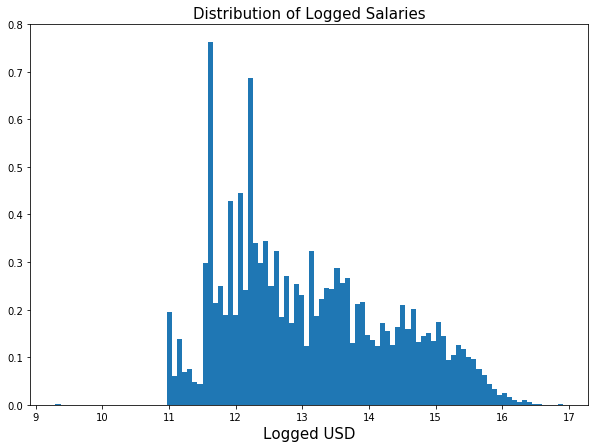

In [9]:
train_df['LogSal'] = np.log1p(train_df.Salaries)

salaries = train_df['LogSal']
density = stats.gaussian_kde(salaries)
f, ax = plt.subplots(figsize=(10,7))
n, x, _ = plt.hist(salaries, bins=100, density=True) 
plt.title('Distribution of Logged Salaries', fontsize = 15)
plt.xlabel('Logged USD', fontsize = 15)
plt.show()

In [10]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]
y_train = train_df.LogSal.values
train_df = train_df.drop('LogSal', axis=1)
df = pd.concat((train_df, test_df)).reset_index(drop=True)
df.drop(['Salaries'], axis=1, inplace=True)
print("all_data size is : {}".format(df.shape))

all_data size is : (32041, 23)


In [11]:
df.isna().sum().sort_values(ascending=False)

GIDP        0
2B          0
playerID    0
yearID      0
stint       0
teamID      0
lgID        0
G           0
AB          0
R           0
H           0
3B          0
SF          0
HR          0
RBI         0
SB          0
CS          0
BB          0
SO          0
IBB         0
HBP         0
SH          0
ID          0
dtype: int64

In [12]:
df = df.dropna()

In [13]:
df = df.drop(['playerID', 'teamID', 'lgID', 'HBP','BB', 'IBB', 'BB'], axis = 1)

In [14]:
train_complete = df[:n_train]
test_complete = df[n_train:]

In [15]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_complete, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [16]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(train_complete, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.max())
print("Min: ",res.min())

Mean: 1.1095898519479348
Min:  1.2041569999386832
Min:  0.9724847994612007


In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

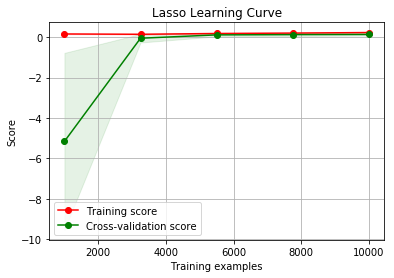

In [18]:
plot_learning_curve(model_lasso, 'Lasso Learning Curve', train_complete, y_train, cv=5)

In [19]:
test_preds = np.expm1(model_lasso.predict(test_complete))
submission = pd.DataFrame()
submission['ID'] = test_ID
submission["Salaries"] = test_preds
submission.to_csv("project.csv", index=False)